In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xarray as xr
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

В чанку знизу ми зшиваємо наші дані за віссю valid_time, оскільки у нас таких файлів декілька, а потім ми перейменовуємо valid_time на просто time, аби отримувати далі більш стандартний атупут

In [ ]:
path_to_era5_files = '/content/drive/MyDrive/AI_project_data/era5_data/*.nc'
era5_files = glob.glob(path_to_era5_files)
era5_files.sort()

if not era5_files:
    print(f"file not found :(")
else:
    era5_dataset = xr.open_mfdataset(era5_files, concat_dim='valid_time', combine='nested')
    era5_dataset = era5_dataset.rename({'valid_time': 'time'})

    print("\n STRUCTURE OF THE DATASET:")
    print(era5_dataset)


 STRUCTURE OF THE DATASET:
<xarray.Dataset> Size: 27MB
Dimensions:    (time: 13176, latitude: 13, longitude: 13)
Coordinates:
  * time       (time) datetime64[ns] 105kB 2023-01-01 ... 2024-08-31T23:00:00
  * latitude   (latitude) float64 104B 48.0 47.75 47.5 47.25 ... 45.5 45.25 45.0
  * longitude  (longitude) float64 104B 29.0 29.25 29.5 ... 31.5 31.75 32.0
    number     int64 8B 0
    expver     (time) <U4 211kB dask.array<chunksize=(4344,), meta=np.ndarray>
Data variables:
    u10        (time, latitude, longitude) float32 9MB dask.array<chunksize=(4344, 13, 13), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 9MB dask.array<chunksize=(4344, 13, 13), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 9MB dask.array<chunksize=(4344, 13, 13), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1

Глянемо, як виглядає взагалі наш датасет:

In [ ]:
sea_level_csv_path = '/content/drive/MyDrive/AI_project_data/sea_level_data/sea_level.csv'
!head -n 10 "{sea_level_csv_path}"

# Credits: EU Copernicus Marine Service information - https://marine.copernicus.eu
# Product: INSITU_BLK_PHYBGCWAV_DISCRETE_MYNRT_013_034
# Dataset: cmems_obs-ins_blk_phybgcwav_mynrt_na_irr
# Variable: Sea water alkalinity per unit mass (ALKW) µmol kg-1

parameter,platformId,platformType,time,longitude,latitude,depth,pressure,value,valueQc
SLEV,42808,TG,2023-06-20T05:00:00.000Z,29.2667,45.4328,0,,1.59,1
SLEV,42808,TG,2023-06-21T05:00:00.000Z,29.2667,45.4328,0,,1.64,1
SLEV,42808,TG,2023-06-22T05:00:00.000Z,29.2667,45.4328,0,,1.66,1
SLEV,42808,TG,2023-06-23T05:00:00.000Z,29.2667,45.4328,0,,1.69,1


В нашому датасеті деякі рядки починаються з "#", це при читанні може спричинити помилки, тому варто було б ігнорувати хештег. Це ми і зробимо при читанні:

In [ ]:
sea_level_csv_path = '/content/drive/MyDrive/AI_project_data/sea_level_data/sea_level.csv'

try:
    sea_level_df = pd.read_csv(sea_level_csv_path, comment='#')

    print("FIRST 5 ROWS FOR SEA LEVEL")
    print(sea_level_df.head())
    print("\n" + "="*50 + "\n")
    print("INFO ABOUT COLUMNS")
    sea_level_df.info()

except FileNotFoundError:
    print(f"file not found :(")
except Exception as e:
    print(f"some another error....idk")

FIRST 5 ROWS FOR SEA LEVEL
  parameter  platformId platformType                      time  longitude  \
0      SLEV       42808           TG  2023-06-20T05:00:00.000Z    29.2667   
1      SLEV       42808           TG  2023-06-21T05:00:00.000Z    29.2667   
2      SLEV       42808           TG  2023-06-22T05:00:00.000Z    29.2667   
3      SLEV       42808           TG  2023-06-23T05:00:00.000Z    29.2667   
4      SLEV       42808           TG  2023-06-24T05:00:00.000Z    29.2667   

   latitude  depth  pressure  value  valueQc  
0   45.4328      0       NaN   1.59        1  
1   45.4328      0       NaN   1.64        1  
2   45.4328      0       NaN   1.66        1  
3   45.4328      0       NaN   1.69        1  
4   45.4328      0       NaN   1.70        1  


INFO ABOUT COLUMNS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   parameter  

Приводимо час в обох табличках до єдиного формату. І найпростіше, що ми можемо зробити - це видалити інформацію про часову зону з даних про рівень моря, аби вони стали такими ж, як і метеодані

In [ ]:
sea_level_df['time'] = pd.to_datetime(sea_level_df['time'])
sea_level_df.set_index('time', inplace=True)
sea_level_ts = sea_level_df[['value']].rename(columns={'value': 'sea_level'})

sea_level_ts.index = sea_level_ts.index.tz_localize(None)

if 'valid_time' in era5_dataset.coords:
    era5_dataset = era5_dataset.rename({'valid_time': 'time'})

station_lat = sea_level_df['latitude'].iloc[0]
station_lon = sea_level_df['longitude'].iloc[0]

weather_at_station = era5_dataset.sel(latitude=station_lat, longitude=station_lon, method='nearest')
weather_df = weather_at_station.to_dataframe()

final_df = pd.merge(sea_level_ts, weather_df[['u10', 'v10', 'msl']], left_index=True, right_index=True, how='inner')


print("FINAL DATASET!!!")
print(final_df.head())
print("\n")
final_df.info()

FINAL DATASET!!!
                     sea_level       u10       v10          msl
time                                                           
2023-06-20 05:00:00       1.59  2.377792 -4.104721  101426.6250
2023-06-21 05:00:00       1.64  1.878677 -2.690338  101529.3125
2023-06-22 05:00:00       1.66  0.197922 -1.920349  101856.9375
2023-06-23 05:00:00       1.69  0.705475  1.978668  101860.3125
2023-06-24 05:00:00       1.70  0.474625  3.164673  101553.8750


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 742 entries, 2023-06-20 05:00:00 to 2024-03-11 06:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sea_level  742 non-null    float64
 1   u10        742 non-null    float32
 2   v10        742 non-null    float32
 3   msl        742 non-null    float32
dtypes: float32(3), float64(1)
memory usage: 20.3 KB


Нам би хотілось зробити візуалізацію наших даних, глянути, чи взагалі все добре. Перед тим нам треба відсортувати наш фінальний датасет за індексом часу

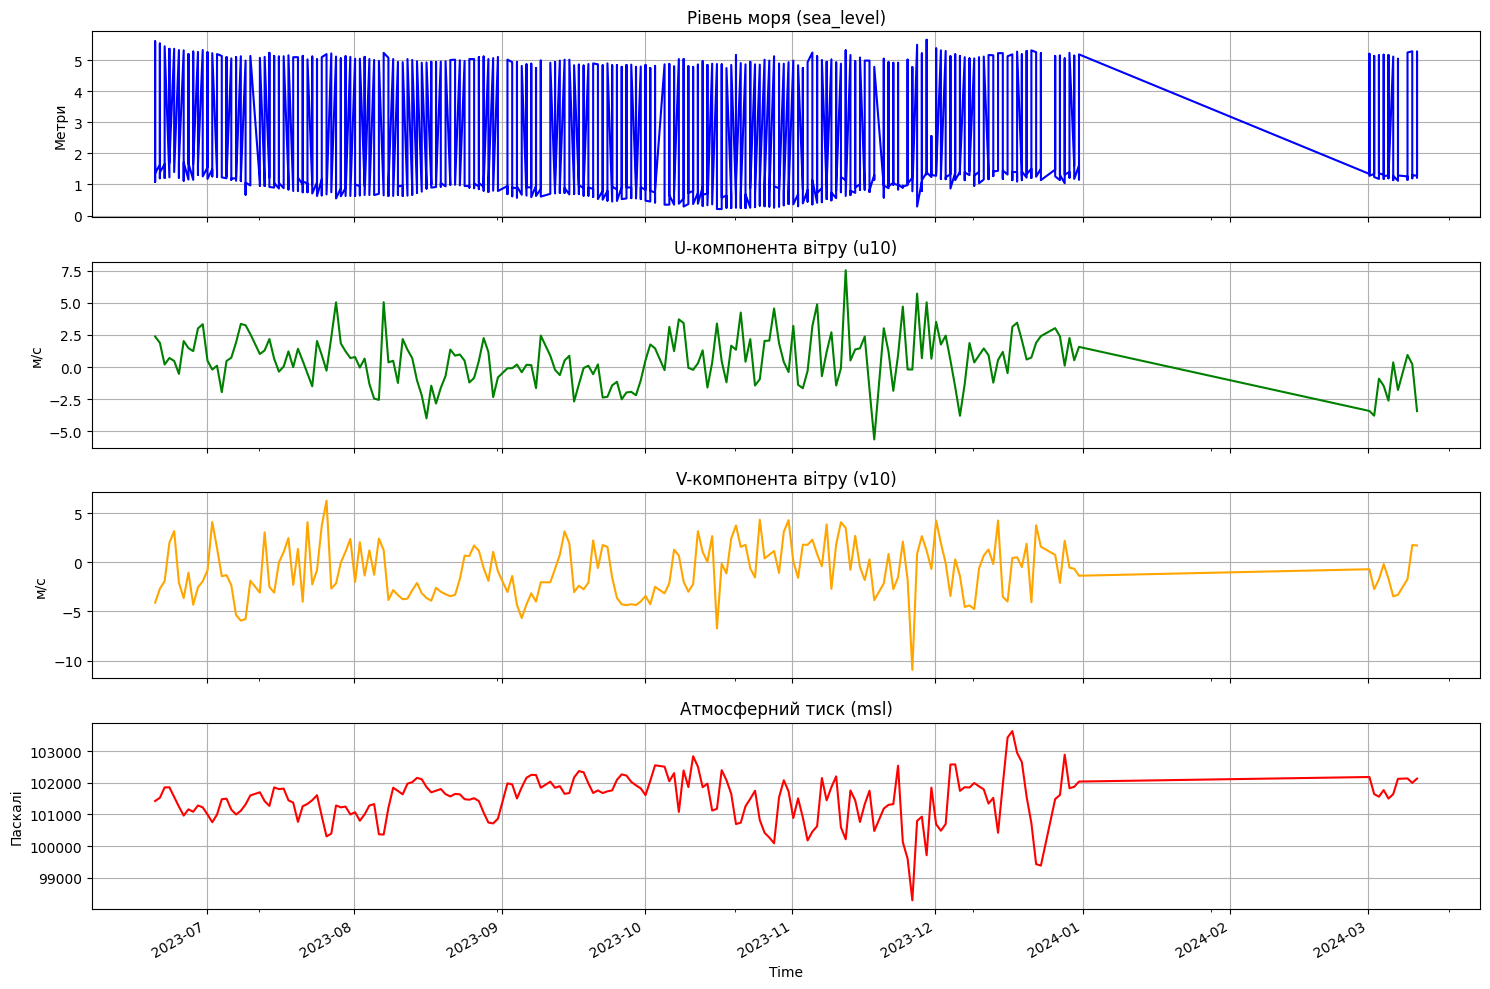

In [ ]:
final_df.sort_index(inplace=True)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)

final_df['sea_level'].plot(ax=axes[0], title='Рівень моря (sea_level)', color='blue')
axes[0].set_ylabel('Метри')
axes[0].grid(True)

final_df['u10'].plot(ax=axes[1], title='U-компонента вітру (u10)', color='green')
axes[1].set_ylabel('м/с')
axes[1].grid(True)

final_df['v10'].plot(ax=axes[2], title='V-компонента вітру (v10)', color='orange')
axes[2].set_ylabel('м/с')
axes[2].grid(True)

final_df['msl'].plot(ax=axes[3], title='Атмосферний тиск (msl)', color='red')
axes[3].set_ylabel('Паскалі')
axes[3].grid(True)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

Що ми тут бачимо? Вітер та тиск виглядають, в принципі, як ми і очікували, тобто вони справді показують природні "коливання" погоди. Але графік з рівнем моря показує надзвичайно часті коливання. Можливо, це і є ефект припливів-відливів.

Для нашої моделі такий шум може бути трохи проблематичним, адже через нього нам складніше буде побачити більш повільні та плавні зміни рівня моря. ЩО ми можемо тут зробити? Найпростіше рішення, на нашу думку, це використати rolling mean, тобто, ми для кожної точки розраховуємо середнє значення з кількох сусідніх точок.

Вікно ми тут будемо брати у 24 години, а center=True дозволить нам зробити середнє значення центрованим, що покращить наш аналіз

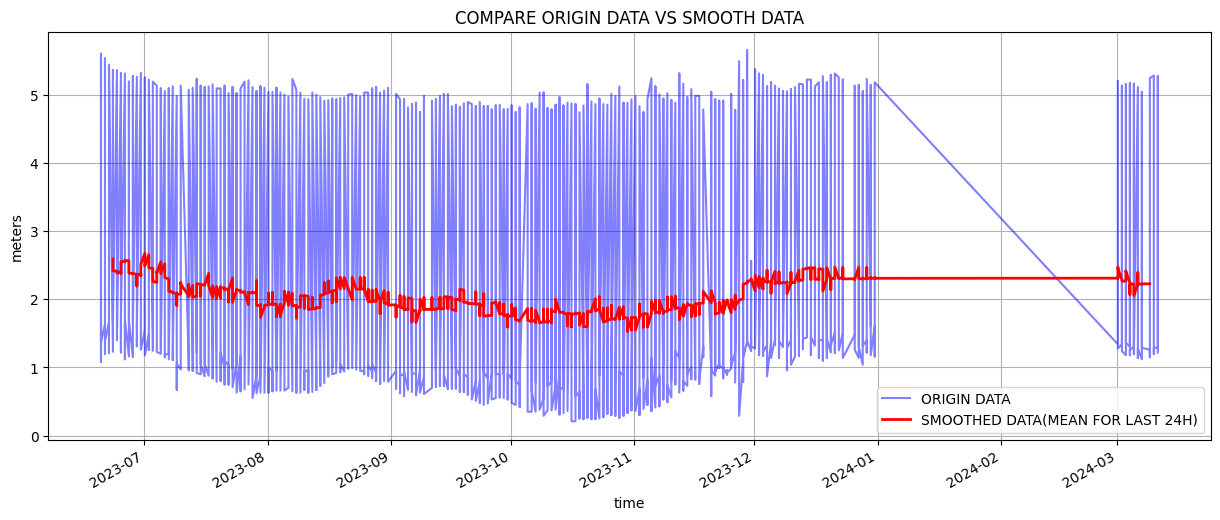

In [ ]:
final_df['sea_level_smoothed'] = final_df['sea_level'].rolling(window=24, center=True).mean()

plt.figure(figsize=(15, 6))
final_df['sea_level'].plot(label='ORIGIN DATA', style='-', alpha=0.5, color='blue')
final_df['sea_level_smoothed'].plot(label='SMOOTHED DATA(MEAN FOR LAST 24H)', style='-', color='red', linewidth=2)
plt.title('COMPARE ORIGIN DATA VS SMOOTH DATA')
plt.ylabel('meters')
plt.legend()
plt.grid(True)
plt.show()

# Ура! Переходимо до підготовки даних до моделі

Ми знаємо, що LSTM не приймає дані у вигляді таблиць, тобто нам треба звести дані до вигялду зразків та послідовностей.

Наша логіка: спочатку ми показуємо моделі дані за певну кількість годин (тут ми беремо за останні 3 дні) і попросимо спрогнозувати рівень моря на кілька годин уперед (беремо на 6)

In [ ]:
features = ['sea_level_smoothed', 'u10', 'v10', 'msl']
data_for_model = final_df[features].copy()

data_for_model.dropna(inplace=True)

def create_sequences(data, input_window, output_horizon):
    X, y = [], []
    for i in range(len(data) - input_window - output_horizon + 1):
        X.append(data[i:(i + input_window)].values)
        y.append(data['sea_level_smoothed'][(i + input_window):(i + input_window + output_horizon)].values)
    return np.array(X), np.array(y)


INPUT_WINDOW = 72
OUTPUT_HORIZON = 6

X, y = create_sequences(data_for_model, INPUT_WINDOW, OUTPUT_HORIZON)

print(f"INPUT FORM (X): {X.shape}")
print(f"OUTPUT FORM (y): {y.shape}")

INPUT FORM (X): (642, 72, 4)
OUTPUT FORM (y): (642, 6)


## CNN+LSTM

Отже, найцікавіше, тренуємо модель

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("DATA IS NORMALIZED AND SEPARATED")
print(f"TRAIN SET SIZE X: {X_train_scaled.shape}")
print(f"TEST SET SIZE X: {X_test_scaled.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    LSTM(units=50, activation='relu'),
    Dense(units=OUTPUT_HORIZON)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

print("\n START TRAINING")
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    validation_split=0.1,
    batch_size=16,
    verbose=1
)

print("\n FINISH!")

DATA IS NORMALIZED AND SEPARATED
TRAIN SET SIZE X: (513, 72, 4)
TEST SET SIZE X: (129, 72, 4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 70, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,138 (94.29 KB)

 Trainable params: 24,138 (94.29 KB)

 Non-trainable params: 0 (0.00 B)


 START TRAINING
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 5.9745 - val_loss: 2.6739
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.1833 - val_loss: 2.2171
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.3892 - val_loss: 0.2902
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.2362 - val_loss: 0.1475
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0708 - val_loss: 0.1319
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0396 - val_loss: 0.1049
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0285 - val_loss: 0.1143
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0239 - val_loss: 0.1454
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0257 - val_loss: 0.0970
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0206 - val_loss: 0.1157
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0223 - val_loss: 0.0964
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33

Тепер ми можемо оцінити результати нашого тренування:

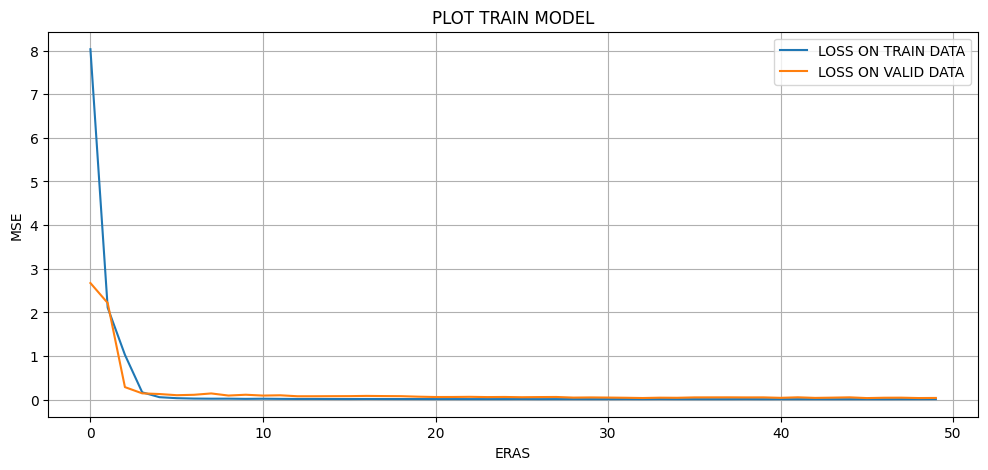

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


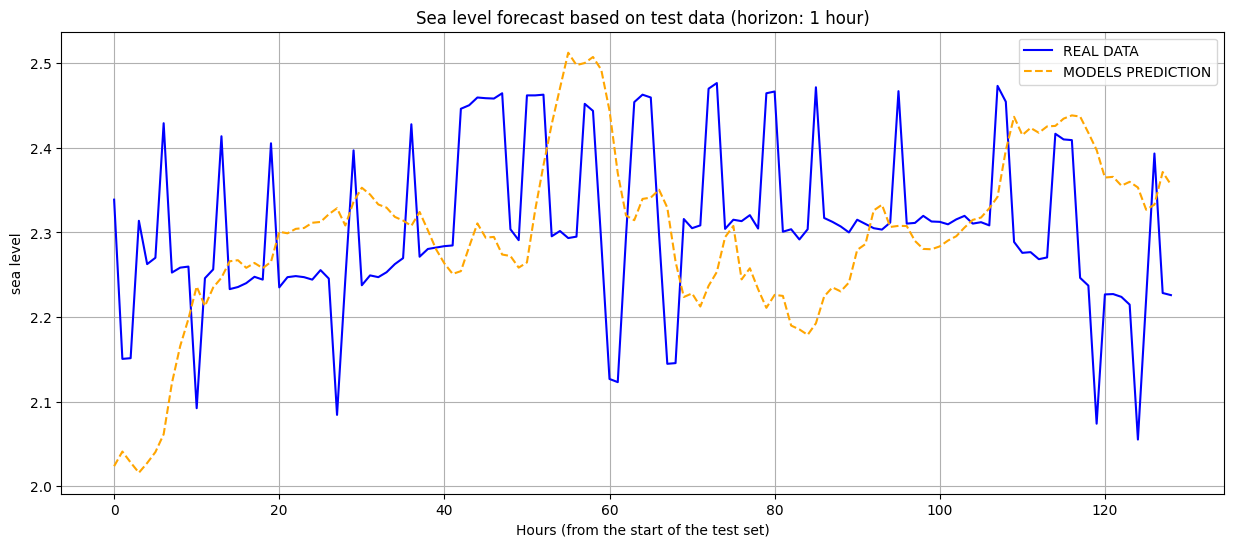

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='LOSS ON TRAIN DATA')
plt.plot(history.history['val_loss'], label='LOSS ON VALID DATA')
plt.title('PLOT TRAIN MODEL')
plt.xlabel('ERAS')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

predictions = model.predict(X_test_scaled)

plot_len = 200
plt.figure(figsize=(15, 6))
plt.plot(y_test[:plot_len, 0], label='REAL DATA', color='blue')
plt.plot(predictions[:plot_len, 0], label='MODELS PREDICTION', color='orange', linestyle='--')
plt.title('Sea level forecast based on test data (horizon: 1 hour)')
plt.xlabel('Hours (from the start of the test set)')
plt.ylabel('sea level')
plt.legend()
plt.grid(True)
plt.show()